In [1]:
import os
import time

from scipy.io import loadmat

from cest_mrf.write_scenario import write_yaml
from cest_mrf.dictionary.generation import generate_mrf_cest_dictionary
from cest_mrf.metrics.crlb import crb_calc
from cest_mrf.write_scenario import write_yaml_dict


from scipy.optimize import minimize, basinhopping

from copy import deepcopy

import pypulseq
import numpy as np
import yaml

import argparse

from configs import ConfigPreclinical
from sequences import write_sequence_preclinical

import matplotlib.pyplot as plt

In [2]:
def gen_dict(x, cfg):
    # Define output filenames
    yaml_fn = cfg['yaml_fn']
    seq_fn = cfg['seq_fn']
    dict_fn = cfg['dict_fn']

    # Write the .yaml according to the config.py file (inside cest_mrf folder)
    write_yaml_dict(cfg, yaml_fn)

    # Write the seq file for a 2d experiment
    # for more info about the seq file, check out the pulseq-cest repository
    seq_defs = {}
    seq_defs['n_pulses'] = 1  # number of pulses
    seq_defs['tp'] = 3  # pulse duration [s]
    seq_defs['td'] = 0  # interpulse delay [s]
    seq_defs['Trec'] = 1  # delay before readout [s]
    seq_defs['Trec_M0'] = 'NaN'  # delay before m0 readout [s]
    seq_defs['M0_offset'] = 'NaN'  # dummy m0 offset [ppm]
    seq_defs['DCsat'] = seq_defs['tp'] / (seq_defs['tp'] + seq_defs['td'])  # duty cycle
    seq_defs['offsets_ppm'] = [3.0] * len(x)  # offset vector [ppm]
    seq_defs['num_meas'] = len(seq_defs['offsets_ppm'])  # number of repetition
    seq_defs['Tsat'] = seq_defs['n_pulses'] * (seq_defs['tp'] + seq_defs['td']) - seq_defs['td']
    seq_defs['B0'] = cfg['b0']  # B0 [T]

    seqid = os.path.splitext(seq_fn)[1][1:]
    seq_defs['seq_id_string'] = seqid  # unique seq id

    # we vary B1 for the dictionary generation
    seq_defs['B1pa'] = x

    # Create .seq file
    write_sequence_preclinical(seq_defs=seq_defs, seq_fn=seq_fn)

    start = time.perf_counter()
    dictionary = generate_mrf_cest_dictionary(seq_fn=seq_fn, param_fn=yaml_fn, dict_fn=dict_fn, num_workers=cfg['num_workers'],
                                    axes='xy')  # axes can also be 'z' if no readout is simulated
    end = time.perf_counter()
    s = (end - start)
    print(f"Dictionary simulation and preparation took {s:.03f} s.")
    
    # dictionary['sig'] = np.array(dictionary['sig']).T
    for key in dictionary.keys():
        if key != 'sig':
            dictionary[key] = np.expand_dims( np.squeeze(np.array(dictionary[key])), 0)
    return dictionary


def crlb_wrap(dictionary, params=None, sigma = 0.03, norm = True, reg=1e-3, verbose=False):
    # divide signals and dict
    dictionary = dictionary.copy()
    signals = dictionary['sig']
    dictionary.pop('sig', None)

    crb, dvars = crb_calc(dictionary=dictionary, signals=signals, sigma=sigma, norm=norm, reg=reg,verbose=verbose)
    # mCRB = np.mean(np.sqrt(CRB+1e-6), axis=0)
    m_crb = np.mean(crb, axis=0)

    # print('Mean CRB matrix (estimation error): \n', [np.sqrt(m_crb[i,i])*100 for i in range(m_crb.shape[0])])
    # m_crb = mCRB[-2:,-2:]
    
    ret_crb = {}

    for i, p in enumerate(dvars):
        if p in params:
            ret_crb[p] = m_crb[i,i]  

    return ret_crb

array([0.33626877, 0.89414382, 0.33910897, 0.24425032, 1.84697722,
       0.38172877, 0.80684919, 0.24949056, 1.09965498, 0.94621582,
       0.14589742, 1.3503177 ])

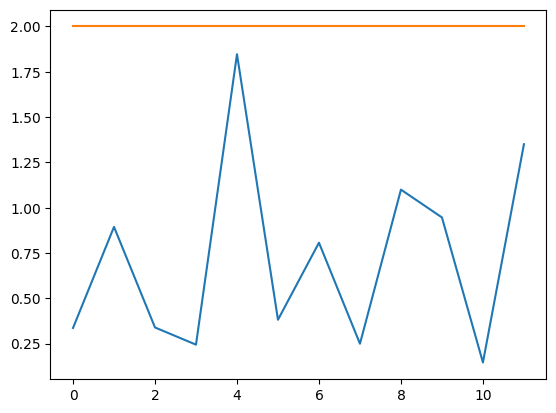

In [3]:
cfg = ConfigPreclinical().get_config()

sig_n = 12

b1_const = [2.0] * sig_n
b1 = np.random.rand(sig_n)*2
plt.plot(b1)
plt.plot(b1_const)
b1

In [4]:
dictionary = gen_dict(b1, cfg)
dict_const = gen_dict(b1_const, cfg)

No MT pools found in param files! specify with "mt_pool"
Found 12259 different parameter combinations.


/home/hash/code/cest/nature_protocols/open-py-cest-mrf/cest_mrf/pypulseq/pypulseq/Sequence/write_seq.py:81: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  arb_grad_mask = grad_lib_values == 'g'
/home/hash/code/cest/nature_protocols/open-py-cest-mrf/cest_mrf/pypulseq/pypulseq/Sequence/write_seq.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  trap_grad_mask = grad_lib_values == 't'


===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========

===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
===== EXTERNAL SEQUENCE #    0 ===========
Future 2 is finished
Future 9 is finished
Future 3 is finished
Future 6 is finished
Future 1 is finished
Future 4 is finished
Future 10 is finished
Future 0 is finished
Future 5 is finished
Future 7 is finished
Future 8 is fi

In [7]:
params = ['fs_0', 'ksw_0']
sigma = 0.008 # noise level for CRB calculation
norm = True # normalize CRB: \sqrt(CRB(p)) / p
reg = 1e-3 # regularization for CRB (information matrix inversion)
verbose = False # verbose output


crb = crlb_wrap(dictionary, params=params, sigma=sigma, norm=norm, reg=reg, verbose=verbose)
crb_const = crlb_wrap(dict_const, params=params, sigma=sigma, norm=norm, reg=reg, verbose=verbose)

print('\nCRLB for random B1')
for p in params:
    print(f'nCRLB for {p}: {np.sqrt(crb[p])*100:.03f}%')

print('\nCRLB for constant B1')
for p in params:
    print(f'nCRLB for {p} const: {np.sqrt(crb_const[p])*100:.03f}%')


CRLB for random B1
nCRLB for fs_0: 11.131%
nCRLB for ksw_0: 14.552%

CRLB for constant B1
nCRLB for fs_0 const: 6883.757%
nCRLB for ksw_0 const: 24426.302%
